In [4]:
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# --- Config ---
DATASET_PATH = "../data/processed/train_instruction.jsonl"

def load_and_parse_data(filepath):
    data = []
    errors = 0
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line)
                
                # Extract parts
                messages = entry['messages']
                user_content = messages[0]['content']
                assistant_content = messages[1]['content']
                
                # 1. Extract DNA Sequence
                dna_match = re.search(r"<dna_start>(.*?)<dna_end>", user_content)
                dna_seq = dna_match.group(1) if dna_match else ""
                
                # 2. Extract Reasoning vs Report
                think_match = re.search(r"<think>(.*?)</think>", assistant_content, re.DOTALL)
                reasoning = think_match.group(1).strip() if think_match else ""
                report = assistant_content.split("</think>")[-1].strip()
                
                # 3. Extract Resistance Levels (for EDA)
                # Looking for lines like "- AZT: High-Level Resistance"
                resistance_levels = re.findall(r": (High-Level|Intermediate|Low-Level|Potential Low-Level|Susceptible)", report)
                
                # 4. Check for Mutation Genes identified
                genes_found = []
                if "PR:" in report: genes_found.append("PR")
                if "RT:" in report: genes_found.append("RT")
                if "IN:" in report: genes_found.append("IN")
                
                data.append({
                    "dna_length": len(dna_seq),
                    "response_length": len(assistant_content),
                    "reasoning_length": len(reasoning),
                    "has_think_tag": bool(think_match),
                    "resistance_count": len(resistance_levels),
                    "high_res_count": resistance_levels.count("High-Level"),
                    "susceptible_count": resistance_levels.count("Susceptible"),
                    "genes_found": ", ".join(genes_found)
                })
            except Exception as e:
                errors += 1
                
    print(f"Successfully loaded {len(data)} examples.")
    print(f"Failed parsing lines: {errors}")
    return pd.DataFrame(data)

In [5]:
# --- 1. Load Data ---
df = load_and_parse_data(DATASET_PATH)

Successfully loaded 3948 examples.
Failed parsing lines: 0


In [8]:
# --- 2. Basic Statistics ---
print("\n=== Dataset Statistics ===")
print(df.describe())


=== Dataset Statistics ===
        dna_length  response_length  reasoning_length  resistance_count  \
count  3948.000000      3948.000000       3948.000000            3948.0   
mean   8912.664134      1793.459726        404.642857              27.0   
std     261.877442       183.424456         16.779985               0.0   
min    8002.000000      1359.000000        391.000000              27.0   
25%    8808.000000      1634.000000        396.000000              27.0   
50%    8935.000000      1825.500000        399.000000              27.0   
75%    9020.000000      1910.000000        401.000000              27.0   
max    9865.000000      3118.000000        468.000000              27.0   

       high_res_count  susceptible_count  
count     3948.000000        3948.000000  
mean         0.425532          25.570922  
std          1.693002           3.046932  
min          0.000000           1.000000  
25%          0.000000          26.000000  
50%          0.000000          27.0000

Text(0.5, 0, 'Length')

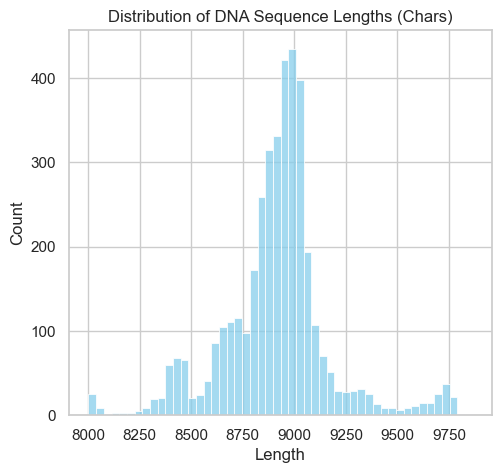

In [9]:
# --- 3. Token/Length Analysis (Crucial for Context Window) ---
# Approximate tokens (1 token ~= 4 chars)
df['total_est_tokens'] = (df['dna_length'] + df['response_length']) / 4

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['dna_length'], bins=50, color='skyblue')
plt.title("Distribution of DNA Sequence Lengths (Chars)")
plt.xlabel("Length")

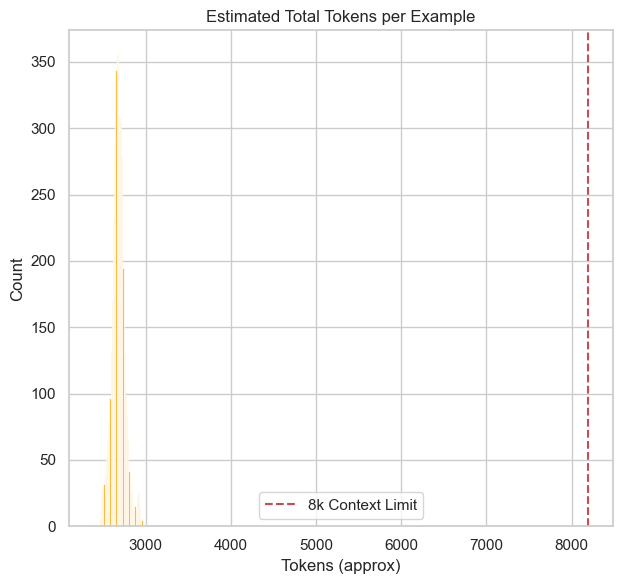

In [10]:
plt.subplot(1, 2, 2)
sns.histplot(df['total_est_tokens'], bins=50, color='orange')
plt.title("Estimated Total Tokens per Example")
plt.xlabel("Tokens (approx)")
plt.axvline(x=8192, color='r', linestyle='--', label='8k Context Limit')
plt.legend()
plt.tight_layout()
plt.show()

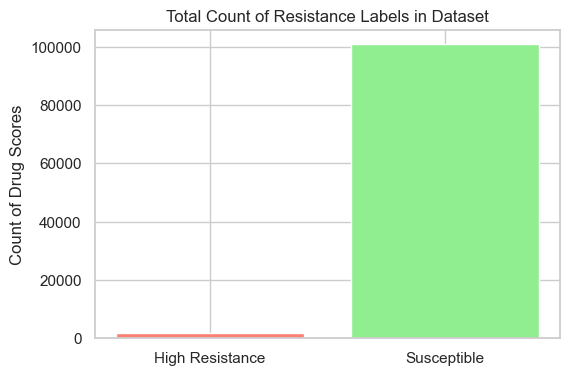

In [11]:
# --- 4. Clinical Content Balance ---
# We don't want a dataset that is 100% susceptible (the model won't learn resistance).
resistance_counts = {
    "High Resistance": df['high_res_count'].sum(),
    "Susceptible": df['susceptible_count'].sum()
}

plt.figure(figsize=(6, 4))
plt.bar(resistance_counts.keys(), resistance_counts.values(), color=['salmon', 'lightgreen'])
plt.title("Total Count of Resistance Labels in Dataset")
plt.ylabel("Count of Drug Scores")
plt.show()

In [14]:
resistance_counts

{'High Resistance': np.int64(1680), 'Susceptible': np.int64(100954)}

In [13]:
# --- 5. Sanity Check: Inspect One Example ---
print("\n=== Random Sample Inspection ===")
sample = df.sample(1).iloc[0]
print(f"DNA Length: {sample['dna_length']}")
print(f"Genes Found: {sample['genes_found']}")
print(f"High Resistance Drugs: {sample['high_res_count']}")

# Re-read raw file to print text
with open(DATASET_PATH, 'r') as f:
    for i, line in enumerate(f):
        if i == sample.name: # Match the random index
            data = json.loads(line)
            print("-" * 50)
            print("ASSISTANT RESPONSE PREVIEW:")
            print(data['messages'][1]['content'][:5000] + "...\n[TRUNCATED]")
            break


=== Random Sample Inspection ===
DNA Length: 8223
Genes Found: PR, RT, IN
High Resistance Drugs: 0
--------------------------------------------------
ASSISTANT RESPONSE PREVIEW:
<think>
Step 1: Analyzing the viral genome sequence for known resistance motifs (PR, RT, IN).
Step 2: Identified surveillance mutations: CA:A14P, CA:I15L, CA:V27I, CA:S41T, CA:M68I, CA:E79D, CA:I91N, CA:A92P...
Step 3: Cross-referencing identified mutations with the Stanford HIVDB scoring algorithm.
Step 4: No significant resistance penalties detected.
Step 5: Generating standard susceptibility report.
</think>

### Clinical HIV Drug Resistance Report

**Genetic Mutations Identified:**
CA: A14P, I15L, V27I, S41T, M68I, E79D, I91N, A92P, N120S, T148I, R154K, E180D, V191I, A194S, G225S
PR: L19V, K43R, D60E, Q61E, I62V, L63S, V77I, I93L
RT: E28K, K32E, V35T, E36A, T39D, S48T, V60I, D121Y, K122E, S134C, S162A, K166R, D177E, Q207E, R211K, A272P, K277R, T286A, E291D, V292I, I293V, E297A, G335D, T338S, R356K, M357K, 

In [16]:
# --- Config ---
AUGMENTED_PATH = "../data/processed/train_instruction_augmented.jsonl"

def load_and_analyze_augmented(filepath):
    data = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line)
                user_content = entry['messages'][0]['content']
                assistant_content = entry['messages'][1]['content']
                
                # 1. Parse Resistance
                is_resistant = "High-Level" in assistant_content or "Intermediate" in assistant_content
                
                # 2. Check for Specific Injected Mutations
                has_k103n = "K103N" in assistant_content
                has_m184v = "M184V" in assistant_content
                has_d30n = "D30N" in assistant_content
                
                # 3. DNA Length (Sanity check that we didn't break strings)
                dna_match = re.search(r"<dna_start>(.*?)<dna_end>", user_content)
                dna_len = len(dna_match.group(1)) if dna_match else 0
                
                data.append({
                    "is_resistant": is_resistant,
                    "dna_length": dna_len,
                    "has_k103n": has_k103n,
                    "has_m184v": has_m184v,
                    "has_d30n": has_d30n
                })
            except Exception:
                pass
                
    return pd.DataFrame(data)

In [17]:
# --- Run Analysis ---
df_aug = load_and_analyze_augmented(AUGMENTED_PATH)

print(f"Total Examples: {len(df_aug)}")

Total Examples: 6436


C:\Users\Asus\AppData\Local\Temp\ipykernel_29400\4243441317.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_resistant', data=df_aug, palette=['lightgreen', 'salmon'])
C:\Users\Asus\AppData\Local\Temp\ipykernel_29400\4243441317.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mutation_counts.keys()), y=list(mutation_counts.values()), palette='viridis')


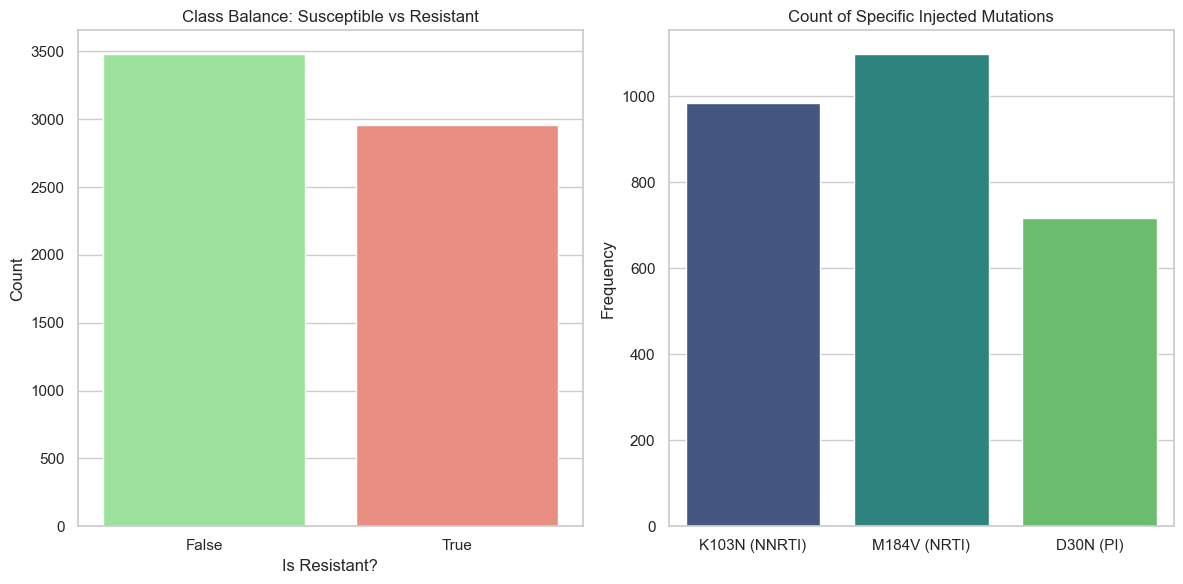

In [19]:
# Subplot 1: Resistance Balance
plt.subplot(1, 2, 1)
sns.countplot(x='is_resistant', data=df_aug, palette=['lightgreen', 'salmon'])
plt.title("Class Balance: Susceptible vs Resistant")
plt.xlabel("Is Resistant?")
plt.ylabel("Count")

# Subplot 2: Specific Mutation Counts
plt.subplot(1, 2, 2)
mutation_counts = {
    "K103N (NNRTI)": df_aug['has_k103n'].sum(),
    "M184V (NRTI)": df_aug['has_m184v'].sum(),
    "D30N (PI)": df_aug['has_d30n'].sum()
}
sns.barplot(x=list(mutation_counts.keys()), y=list(mutation_counts.values()), palette='viridis')
plt.title("Count of Specific Injected Mutations")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [26]:
# --- 2. Sanity Check Text ---
print("\n=== Validation of Augmented Text ===")
# Find one example that has M184V to verify the text rewrite
sample_row = df_aug[df_aug['has_m184v'] == True].sample(1)
sample_idx = sample_row.index[0]

with open(AUGMENTED_PATH, 'r') as f:
    for i, line in enumerate(f):
        if i == sample_idx:
            data = json.loads(line)
            print(f"Checking Entry #{i} (Should have M184V):")
            print("-" * 60)
            print(data['messages'][1]['content'])
            break


=== Validation of Augmented Text ===
Checking Entry #4423 (Should have M184V):
------------------------------------------------------------
<think>
Step 1: Analyzing the viral genome sequence for known resistance motifs (PR, RT, IN).
Step 2: Identified surveillance mutations: RT: M184V...
Step 3: Cross-referencing identified mutations with the Stanford HIVDB scoring algorithm.
Step 4: Significant resistance penalties detected for: LMV (3TC), FTC (FTC).
Step 5: Generating standard susceptibility report.
</think>

### Clinical HIV Drug Resistance Report

**Genetic Mutations Identified:**
CA: A14P, S41A, L83M, R132K, L136M, A194S
PR: L33V, N37A, I64V
RT: K104R, K122E, T200A, V245I, A272P, K277R, L283I, I293V, E297A, D324E, I326V, I329L, R356K, V365I, A376S, T377Q, A400T, T403V, L452S, S468P, L491S, K527N
IN: K14R, L101I, I113V, S119P, T125A, G193E, D256E, D286N

**Resistance Profile:**
**CAI**
- LEN (LEN): Susceptible

**PI**
- ATV (ATV/r): Susceptible
- DRV (DRV/r): Susceptible
- FPV (F